#### Chain Of Thoughts With RAG
What is Chain-of-Thought (CoT) in RAG?

CoT reasoning breaks down a complex question into intermediate steps, and allows retrieval + reflection at each step before answering.

User Query
   ↓
- Step 1: Decompose question → sub-steps (Reason)
- Step 2: Retrieve docs per step (Act)
- Step 3: Combine context (Observe)
- Step 4: Final answer generation (Reflect)

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

/home/miguel/miniconda3/envs/RAG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -------------------------------
# 1. Prepare Vectorstore
# -------------------------------
docs = TextLoader("research_notes.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [4]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [5]:
# -------------------------------
# 2. LangGraph State Definition
# -------------------------------
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [6]:
# -------------------------------
# 3. Nodes
# -------------------------------

# a. Plan sub-questions
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs})


In [7]:
# b. Retrieve for each step
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})


In [8]:
# c. Generate Final Answer
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
You are answering a complex question using reasoning and retrieved documents.

Question: {state.question}

Relevant Information:
{context}

Now synthesize a well-reasoned final answer.
"""
    result = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result})

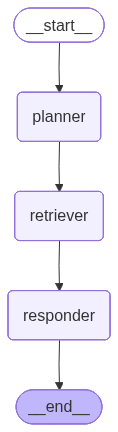

In [9]:
# -------------------------------
# 4. LangGraph Graph
# -------------------------------
builder = StateGraph(RAGCoTState)
builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [10]:
# -------------------------------
# 5. Run CoT RAG Agent
# -------------------------------
if __name__ == "__main__":
    query = "what are the additional eperiments in Transformer eveluation?"
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\n🪜 Reasoning Steps:", final["sub_steps"])
    print("\n✅ Final Answer:\n", final["answer"])


🪜 Reasoning Steps: ['To address the question of what additional experiments might be involved in Transformer evaluation, we can break it down into a few reasoning steps:', '1. **Identify the Standard Evaluation Metrics**:', 'Begin by considering the typical evaluation metrics and experiments used for evaluating Transformer models, such as BLEU scores for translation tasks, accuracy for classification, or perplexity for language modeling. This helps set a baseline for standard evaluations.', '2. **Determine Areas for Additional Experiments**:', 'Consider areas where additional experiments might provide deeper insights or improvements. This could include evaluating model robustness to adversarial inputs, performance on zero-shot or few-shot tasks, or efficiency evaluations under constrained resources (e.g., memory or computational power).', '3. **Explore Experiments for Domain-Specific Evaluation**:', 'Identify any domain-specific factors that might require unique experimental setups, s